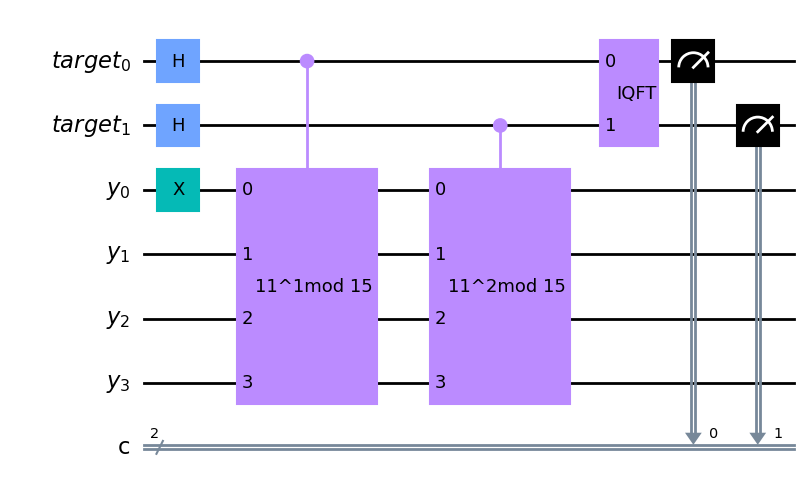

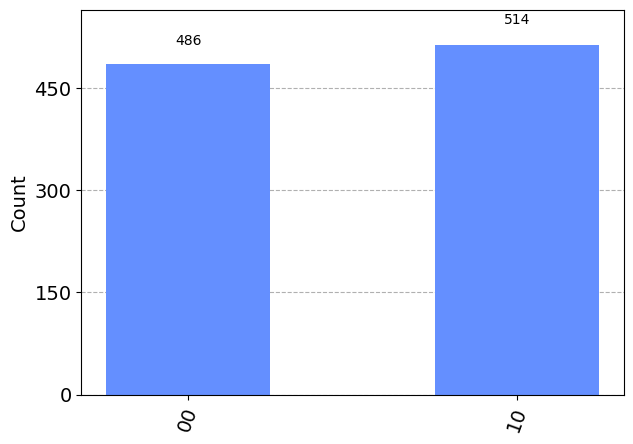

Total counts for qubit states are: {'10': 514, '00': 486}
    Binary    Decimal      Phase   Fraction     Peroid
        10          2        0.5        1/2          2
        00          0        0.0          0          1


In [5]:
#Exercise7-4 設計量子程式建構使用 2 個量子計數位元，對應 𝑓(𝑥) = 11^𝑥 (mod 15) 的量子相位估測線路
#N=15 a=11
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister,execute
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import pi
from fractions import Fraction

def qc_mod15(a,power):
    #根據a計算出mod 15對應的U
    assert a in [2,4,7,8,11,13], 'Invalid value of argument a:'+str(a)
    qrt = QuantumRegister(4,'target') #0~14，以2的4次方足夠放下
    U = QuantumCircuit(qrt)
    for i in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4,11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in[7,11,13]:
            for j in range(4):
                U.x(j)
    U = U.to_gate()
    U.name = f'{a}^{power}mod 15'
    C_U = U.control() #添加控制位元
    return C_U

def iqft(n):
    #逆進行量子傅立葉變換
    br = QuantumRegister(n,'b')
    qc = QuantumCircuit(br)
    for sbit in range(n//2):
        qc.swap(sbit,n-sbit-1)#添加swap
    for hbit in range(0,n,1):
        for cbit in range(hbit-1,-1,-1):
            qc.cp(-pi/2**(hbit-cbit),cbit,hbit)#添加control p閘
        qc.h(hbit)#添加h閘
    return qc

def qpf15(count_number,a):
    target_register = QuantumRegister(target_number,'target')
    y_register = QuantumRegister(4,'y')#mod 15
    creg = ClassicalRegister(target_number,'c')
    qc = QuantumCircuit(target_register,y_register,creg)
    for hbit in range(count_number):
        qc.h(hbit)
    qc.x(y_register[0]) #將要測量的狀態設為|1>
    #添加受控U閘
    for cbit in range(count_number):
        qc.append(qc_mod15(a,2**cbit),[cbit] + list(range(count_number,count_number+4)))#以cbit作為控制位元，count_number~count_number+3位元(即y_register)為目標位元
    qc.append(iqft(count_number).to_gate(label='IQFT'),range(count_number)) #對target進行逆量子傅立葉變換
    qc.measure(range(count_number),creg)
    return qc

target_number  = 2 #計數位元
a = 11
qc = qpf15(target_number,a)
display(qc.draw('mpl'))

#進行模擬
sim = AerSimulator()
job = execute(qc,backend=sim,shots=1000)
result = job.result()
counts = result.get_counts(qc)
display(plot_histogram(counts))
print("Total counts for qubit states are:",counts)
print('%10s %10s %10s %10s %10s' % ('Binary','Decimal','Phase','Fraction','Peroid'))
for akey in counts.keys():
    dec = int(akey,base=2)#轉十進制
    phase = dec/(2**target_number)#得到相位，eigenvalue = e^(2*pi*i*phase)，i為複數
    frac=Fraction(phase).limit_denominator(15) #設定分母最大值為15方便取得peroid
    period=frac.denominator #週期：phase = s/r，故取分母r為peroid
    print('%10s %10s %10s %10s %10s' % (akey,dec,phase,frac,period))